## Pardocs Topic Classification (WIP)

Exploratory attempt at predicting the categories of [Malaysian parliamentary docs](http://pardocs.sinarproject.org/). Specifically, parliamentary questions addressed to the Prime Minister (Perdana Menteri), are usually varied. The aim is to build a model trained on all other pardocs addressed to the remaining 24 ministries to be able to narrow down the topic of PM-addressed questions to these 24 categories.

In [5]:
import pickle, sklearn, pprint
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd

In [88]:
df_all = pickle.load(open('parlMP.p', 'rb'))

In [89]:
#Clean data
df_all = df_all[df_all['ministry']!=""]
df_all = df_all[df_all['minister']!=""]

#Remove Perdana Menteri entries
df = df_all
df = df[df['ministry']!="perdana menteri"]  #entries we want to predict


In [33]:
X = df['text']
y = df['ministry']

#Train-test-dev split
X_devset, X_heldout, y_devset, y_heldout = train_test_split(X, y, train_size = 0.6)
#Train:0.6, Val:0.2, Test:0.2
X_train, X_test, y_train, y_test = train_test_split(X_devset, y_devset, train_size = 0.6, stratify=y_devset)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size = 0.5)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Get TFIDF matrices of train and test sets
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.fit_transform(X_train_counts)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train= X_train_tfidf

In [36]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test = X_test_tfidf

## Preliminary benchmarking

In [ ]:
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density

In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

   
    print("classification report:")
    clf_rep = metrics.precision_recall_fscore_support(y_test, pred)
    out_dict = {
                 "precision" :clf_rep[0]
                ,"recall" : clf_rep[1]
                ,"f1-score" : clf_rep[2]
                ,"support" : clf_rep[3]
                }
    
    out_df = pd.DataFrame(out_dict, index = clf.classes_)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    pprint.pprint(out_df)

    #print("confusion matrix:")
    #pprint.pprint(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    ave_f1_score = clf_rep[2][-1]
    return clf_descr, acc_score, ave_f1_score, train_time, test_time

In [81]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:299: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 1.268s
test time:  0.006s
accuracy:   0.870
dimensionality: 25119
density: 0.999876
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.823529   0.875000   
menteri dalam negeri                                0.918728   0.855263   
menteri kemajuan luar bandar dan wilayah            0.500000   0.800000   
menteri kerja raya                                  0.813559   0.750000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.885350   0.852761   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.937500   1.000000   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.84

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 1.363s
test time:  0.007s
accuracy:   0.852
dimensionality: 25119
density: 0.149173
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.666667   0.666667   
menteri dalam negeri                                0.903226   0.851351   
menteri kemajuan luar bandar dan wilayah            0.571429   0.600000   
menteri kerja raya                                  0.884615   0.920000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.571429   0.500000   
menteri kewangan                                    0.890365   0.893333   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.83

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 2.249s
test time:  0.007s
accuracy:   0.867
dimensionality: 25119
density: 0.457922
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.666667   0.833333   
menteri dalam negeri                                0.914286   0.859060   
menteri kemajuan luar bandar dan wilayah            0.636364   0.636364   
menteri kerja raya                                  0.813559   0.750000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.882353   0.870968   
menteri komunikasi dan multimedia                   0.285714   0.500000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.83

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


test time:  0.333s
accuracy:   0.800
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.533333   0.666667   
menteri dalam negeri                                0.845902   0.741379   
menteri kemajuan luar bandar dan wilayah            0.500000   0.555556   
menteri kerja raya                                  0.862069   0.806452   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.000000   0.000000   
menteri kewangan                                    0.838284   0.835526   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.733333   0.846154   
menteri pelancongan dan kebudayaan                  0.900000   0.931034   
menteri pembangunan wanita keluarga dan masyarakat  0.857143   0.857143   
menteri pendidikan                      

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 3.515s
test time:  0.091s
accuracy:   0.777
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.714286   1.000000   
menteri dalam negeri                                0.817891   0.703297   
menteri kemajuan luar bandar dan wilayah            0.166667   1.000000   
menteri kerja raya                                  0.872727   0.857143   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.000000   0.000000   
menteri kewangan                                    0.769231   0.675000   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.903226   1.000000   
menteri pelancongan dan kebudayaan                  0.984127   0.968750   
menteri pembangunan wanita keluarga dan masyarakat  0.444444   1.000000   
menteri pendidikan   

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 1.136s
test time:  0.006s
accuracy:   0.865
dimensionality: 25119
density: 1.000000
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.823529   0.875000   
menteri dalam negeri                                0.908451   0.843137   
menteri kemajuan luar bandar dan wilayah            0.470588   0.666667   
menteri kerja raya                                  0.813559   0.750000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.886731   0.867089   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.81

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 1.464s
test time:  0.007s
accuracy:   0.878
dimensionality: 25119
density: 0.358170
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.823529   0.875000   
menteri dalam negeri                                0.903915   0.846667   
menteri kemajuan luar bandar dan wilayah            0.695652   0.666667   
menteri kerja raya                                  0.872727   0.857143   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.901961   0.890323   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.941176   0.941176   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.84

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 1.706s
test time:  0.005s
accuracy:   0.862
dimensionality: 25119
density: 0.001778
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.705882   0.750000   
menteri dalam negeri                                0.906475   0.857143   
menteri kemajuan luar bandar dan wilayah            0.600000   0.666667   
menteri kerja raya                                  0.833333   0.757576   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.800000   1.000000   
menteri kewangan                                    0.883721   0.886667   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.952381   0.937500   
menteri pembangunan wanita keluarga dan masyarakat  0.88

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 3.960s
test time:  0.008s
accuracy:   0.865
dimensionality: 25119
density: 0.005514
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.705882   0.750000   
menteri dalam negeri                                0.913043   0.868966   
menteri kemajuan luar bandar dan wilayah            0.608696   0.583333   
menteri kerja raya                                  0.814815   0.814815   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.800000   1.000000   
menteri kewangan                                    0.894040   0.894040   
menteri komunikasi dan multimedia                   0.285714   0.500000   
menteri luar negeri                                 0.882353   0.882353   
menteri pelancongan dan kebudayaan                  0.935484   0.935484   
menteri pembangunan wanita keluarga dan masyarakat  0.75

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 5.653s
test time:  0.008s
accuracy:   0.875
dimensionality: 25119
density: 0.059265
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.823529   0.875000   
menteri dalam negeri                                0.910394   0.858108   
menteri kemajuan luar bandar dan wilayah            0.636364   0.636364   
menteri kerja raya                                  0.842105   0.800000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.889610   0.872611   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.88

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 0.069s
test time:  0.044s
accuracy:   0.775
dimensionality: 25119
density: 1.000000
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.363636   1.000000   
menteri dalam negeri                                0.817276   0.723529   
menteri kemajuan luar bandar dan wilayah            0.400000   0.750000   
menteri kerja raya                                  0.840000   0.913043   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.800000   1.000000   
menteri kewangan                                    0.798780   0.740113   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.857143   0.960000   
menteri pembangunan wanita keluarga dan masyarakat  0.66

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 1.446s
test time:  0.008s
accuracy:   0.857
classification report:
                                                    f1-score  precision  \
menteri belia dan sukan                             0.777778   0.777778   
menteri dalam negeri                                0.911661   0.848684   
menteri kemajuan luar bandar dan wilayah            0.470588   0.666667   
menteri kerja raya                                  0.813559   0.750000   
menteri kesejahteraan bandar perumahan dan kera...  0.000000   0.000000   
menteri kesihatan                                   0.666667   0.666667   
menteri kewangan                                    0.874598   0.850000   
menteri komunikasi dan multimedia                   0.000000   0.000000   
menteri luar negeri                                 0.909091   0.937500   
menteri pelancongan dan kebudayaan                  0.918033   0.933333   
menteri pembangunan wanita keluarga dan masyarakat  0.750000   0.900000   
menteri pendidikan   

/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/metamatical/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


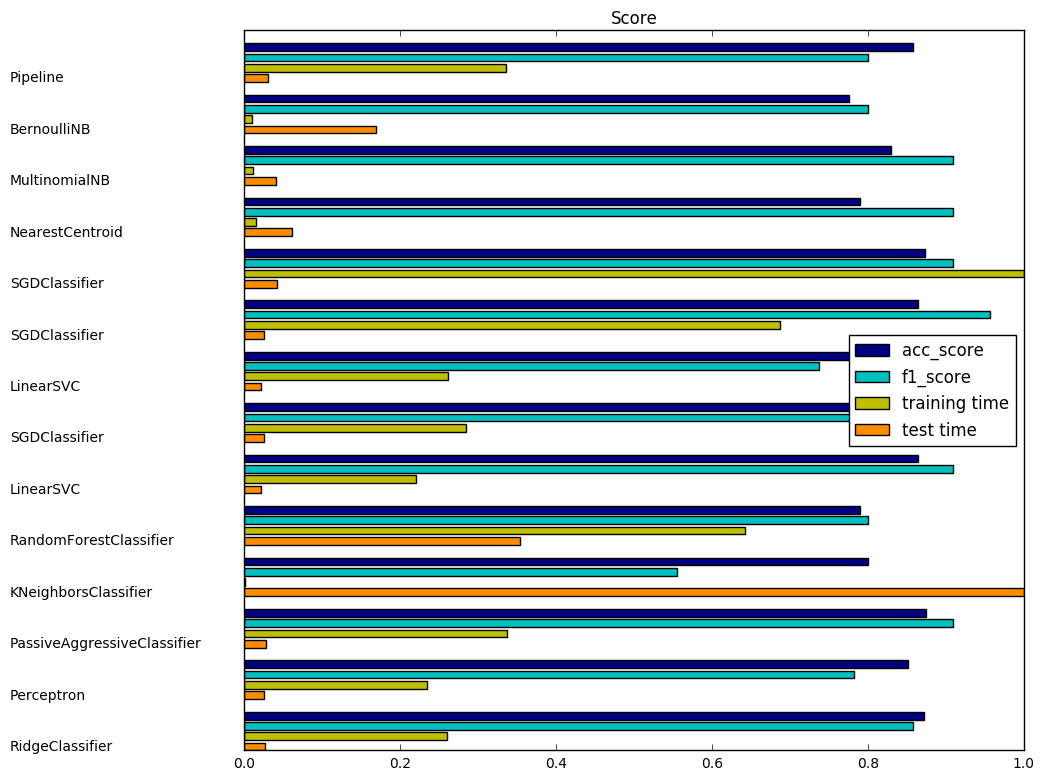

In [80]:
#Performance plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(5)]

clf_names, acc_score, f1_score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices + .6, acc_score, .15, label="acc_score", color='navy')
plt.barh(indices + .4, f1_score, .15, label="f1_score", color='c')
plt.barh(indices + .2, training_time, .15, label="training time", color='y')
plt.barh(indices, test_time, .15, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

The results benchmarked so far are not very impressive, and it's clear why:
There are clear class imbalances in our training dataset, making it more likely to overfit to classes with many training examples. This is obvious from the low F1-scores for underrepresented classes such as Menteri Sumber Manusia. Since the limiting sample size is 4 for the least represented class (Menteri Sains Teknologi dan Inovasi), we would be losing information by merely resampling our dataset. 


In [90]:
df_all['ministry'].value_counts()

perdana menteri                                                 1682
menteri dalam negeri                                            1227
menteri kewangan                                                1158
menteri pendidikan                                               765
menteri sumber asli dan alam sekitar                             314
menteri perdagangan dalam negeri koperasi dan kepenggunaan       304
menteri perdagangan antarabangsa dan industri                    293
menteri pelancongan dan kebudayaan                               254
menteri kerja raya                                               252
menteri pertanian dan industri asas tani                         177
menteri pertahanan                                               174
menteri luar negeri                                              133
menteri perusahaan perladangan dan komoditi                      120
menteri wilayah persekutuan                                      118
menteri pembangunan wanita keluarg

Some approaches to try in the future to combat these class imbalances:

- Set class weight during train time based on distribution of samples
- Oversample the underrepresented classes, eg. via the creation of synthetic samples such as in the SMOTE algorithm. (https://github.com/scikit-learn-contrib/imbalanced-learn)
- P
- Bagging/boosting. #still need to oversample for classes with low number of examples.
- One versus all classifiers #still need to oversample for classes with low number of examples.

Till then, this project is on hold.


## Class weights

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

def benchmark_balancedWeights(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train, class_weight=class_weight)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

   
    print("classification report:")
    clf_rep = metrics.precision_recall_fscore_support(y_test, pred)
    out_dict = {
                 "precision" :clf_rep[0]
                ,"recall" : clf_rep[1]
                ,"f1-score" : clf_rep[2]
                ,"support" : clf_rep[3]
                }
    
    out_df = pd.DataFrame(out_dict, index = clf.classes_)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    pprint.pprint(out_df)

    #print("confusion matrix:")
    #pprint.pprint(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    ave_f1_score = clf_rep[2][-1]
    return clf_descr, acc_score, ave_f1_score, train_time, test_time